In [1]:
print('Добрый день!!!')

Добрый день!!!


# Прогнозирование временных рядов на карте

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Подготовка данных

In [7]:
df = pd.read_csv('yellow_tripdata_2016-05.csv',
                 usecols     = ['tpep_pickup_datetime',
                                'pickup_longitude',
                                'pickup_latitude',
                                'tpep_dropoff_datetime',
                                'trip_distance',
                                'passenger_count'],
                 parse_dates = ['tpep_pickup_datetime',
                                'tpep_dropoff_datetime'],
                 header      = 0,
                 sep         = ',')

In [8]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude
0,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040
1,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751
2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573
3,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601
4,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192


In [9]:
start = df.shape[0]
df = df[( df.passenger_count > 0) &
        ( df.trip_distance != 0) &
        ((df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.seconds > 0) &
        ( df.pickup_longitude >= -74.25559) &
        ( df.pickup_longitude <= -73.70001) & 
        ( df.pickup_latitude  >= 40.49612) &
        ( df.pickup_latitude  <= 40.91553)]
print(start - df.shape[0])

210332


## Агрегация по часам и областям

In [10]:
# Округление до часов
df.tpep_pickup_datetime  = df.tpep_pickup_datetime.dt.floor('H')
df[1000:1005]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude
1023,2016-05-04 22:00:00,2016-05-04 22:23:26,1,0.41,-73.983994,40.752243
1024,2016-05-04 22:00:00,2016-05-04 23:04:46,2,13.72,-73.992119,40.749290
1025,2016-05-04 22:00:00,2016-05-04 22:38:51,1,4.76,-73.987297,40.733070
1026,2016-05-04 22:00:00,2016-05-04 22:35:29,1,2.30,-73.990440,40.745701
1027,2016-05-04 22:00:00,2016-05-04 22:32:42,1,2.10,-73.990944,40.761005


In [11]:
regions = pd.read_csv('regions.csv', sep = ';', header=0)
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [12]:
x_edges = [ x for x in sorted( set(regions.west).union(set(regions.east)))  ]
y_edges = [ y for y in sorted( set(regions.north).union(set(regions.south)))]

In [13]:
def getRegionNumber(longitude, latitude, bins = 50):
    """Старая функция"""
    x = 0
    y = 0
    n = 0
    
    q = len(x_edges) - 1
    
    for i in range(q):
        if (float(longitude) > float(x_edges[i])) &\
           (float(longitude) < float(x_edges[(i+1)])):
            x = i + 1
        if (float(latitude) > float(y_edges[i])) &\
           (float(latitude) < float(y_edges[(i+1)])):
            y = i + 1
        z = (x - 1) * bins + y
    return z

getRegionNumber(-73.9856715, 40.7484831)

1231

In [15]:
df['region'] = df.apply( lambda r: getRegionNumber(r['pickup_longitude'],
                                                   r['pickup_latitude']), axis = 1)

In [18]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,region
0,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1233
1,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1180
2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1180
3,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1173
4,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1130


In [19]:
%%time 
df.to_csv('yt_2016-05_rs.csv',
          columns = ['tpep_pickup_datetime', 
                     'region'],
          index   = False )

Wall time: 1min 11s


In [20]:
dfg = df.groupby(['tpep_pickup_datetime','region']).size().reset_index().rename(columns={0: 'trips'})
dfg.head()

,tpep_pickup_datetime,region,trips
0,2016-05-01,1015,1
1,2016-05-01,1017,1
2,2016-05-01,1029,3
3,2016-05-01,1030,1
4,2016-05-01,1033,4


In [21]:
import itertools
hours = pd.date_range(start  = '2016-05-01',
                      end    = '2016-06-01',
                      freq   = 'h',
                      closed = 'left')
dft = pd.DataFrame(itertools.product(hours, range(1, 2501)),
                   columns = ['tpep_pickup_datetime', 'region'])

dfg = dft.merge(dfg,
                on  = ['tpep_pickup_datetime', 'region'],
                how = 'left').fillna({'trips': 0})
dfg['trips'] = dfg['trips'].astype(np.int64)

In [24]:
dfg.head(9)

,tpep_pickup_datetime,region,trips
0,2016-05-01,1,0
1,2016-05-01,2,0
2,2016-05-01,3,0
3,2016-05-01,4,0
4,2016-05-01,5,0
5,2016-05-01,6,0
6,2016-05-01,7,0
7,2016-05-01,8,0
8,2016-05-01,9,0


In [25]:
dfg.shape

(1860000, 3)

## Задания

In [26]:
ESB = getRegionNumber(-73.9856715, 40.7484831)
ESB

1231

Populating the interactive namespace from numpy and matplotlib


Text(0.5, 1.0, 'Колличество поездок от времени из сектора Empire State Building (40.748, -73.985)')

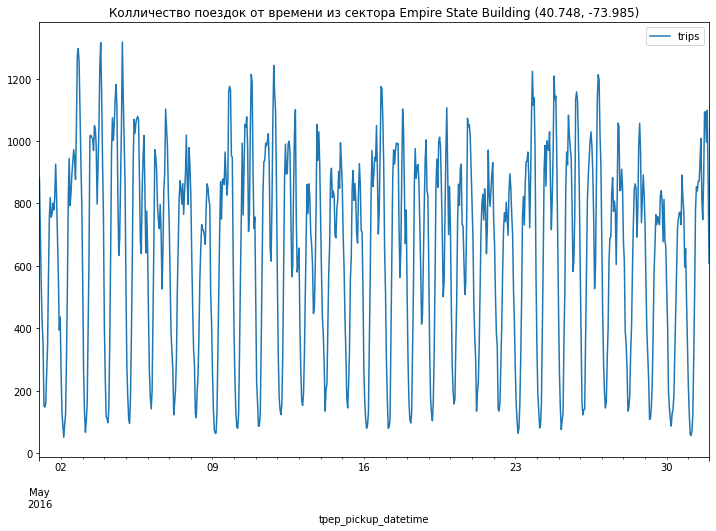

In [27]:
import matplotlib.pyplot as plt
%pylab inline


dfg[ dfg.region == ESB ][['tpep_pickup_datetime','trips']].\
     set_index('tpep_pickup_datetime').\
     plot(figsize=(12, 8))
plt.title('Колличество поездок от времени из сектора Empire State Building (40.748, -73.985)')

In [28]:
dfg[dfg['trips'] == 0].shape[0]

1718238

In [23]:
//

SyntaxError: invalid syntax (<ipython-input-23-8d06436c33a3>, line 1)